In [2]:
import numpy as np 
import sys, os
sys.path.append('../Netket/')
import netket as nk
from jax import numpy as jnp
import itertools
from scipy.special import comb
from jax import jit, vmap
import jax
import matplotlib.pyplot as plt 


/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
hilbert = nk.hilbert.Spin(s=0.5, N=4)

In [4]:
hstates = hilbert.all_states()
hilbert.states_to_numbers(hstates)

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],      dtype=int32)

In [5]:
def return_parity(bitstring):
    '''
    bitstring is a cluster, ex s1s2, or s1s2s3s4 etc
    type of bitstring: jnp.array, dtype=jnp.int8
    returns +1 if even parity, -1 if odd parity
    '''
    par = jnp.prod(bitstring,axis=-1,dtype=jnp.int8) #Since these are spin states +1 and -1
    return par 

def naive_cluster_expansion_mat(hilbert):
    '''Compute cluster expansion matrix up to a given maximum cluster size.
    for now only works for spin-1/2 systems
    '''
    # n_sites = hilbert.n_sites
    n_sites = hilbert.size
    hstates = hilbert.all_states()
    matsize = 2**n_sites
    mat = jnp.ones((matsize, matsize),dtype=jnp.int8)
    for state_idx, state in enumerate(hstates):
        start_idx = 1 #First column is all ones, so start from second column
        for cluster_size in jnp.arange(1, n_sites + 1):
            clusters = jnp.array(list(itertools.combinations(state, cluster_size)))
            rowvals = return_parity(clusters)
            mat = mat.at[state_idx, start_idx: start_idx + int(comb(n_sites, cluster_size))].set(rowvals)
            start_idx += int(comb(int(n_sites), cluster_size))
    return mat


In [6]:
naive_cluster_expansion_mat(nk.hilbert.Spin(s=0.5, N=2))

Array([[ 1,  1,  1,  1],
       [ 1,  1, -1, -1],
       [ 1, -1,  1, -1],
       [ 1, -1, -1,  1]], dtype=int8)

In [7]:
from jax import jit
from jax import numpy as jnp
import numpy as np
import itertools

@jit
def fwht(x):
    """In-place Fast Walsh–Hadamard Transform (returns transformed vector).
    Supports complex inputs (uses complex128 internally).
    Length of x must be a power of two.
    """
    x = x.astype(jnp.complex128)
    n = x.shape[0]
    h = 1
    while h < n:
        x = x.reshape(-1, 2 * h)
        left = x[:, :h]
        right = x[:, h:2 * h]
        x = jnp.concatenate([left + right, left - right], axis=1)
        x = x.reshape(n)
        h *= 2
    return x

# Helper that maps your hilbert ordering to FWHT ordering, runs FWHT and returns coeffs in cluster-matrix column order
def fwht_coeffs_in_cluster_col_order(logpsi, hilbert):
    """Compute coefficients c solving H c = logpsi using FWHT.
   Usage: fwht_coeffs_in_cluster_col_order(logpsi, hilbert)
   where logpsi is a vector of log wavefunction amplitudes in the canonical netket ordering.   
    """
    n_sites = hilbert.size
    hstates = np.array(hilbert.all_states())  # shape (n_states, n_sites) with values +1/-1

    # Map spins s in {+1,-1} -> bits b in {0,1} with convention b=1 when s==-1
    b = ((1 - hstates) // 2).astype(np.int64)
    powers = (1 << np.arange(n_sites)).astype(np.int64)
    indices = (b * powers).sum(axis=1)
    perm = np.argsort(indices)  # mapping FWHT index -> row

    psi_arr = jnp.array(logpsi)
    psi_by_index = psi_arr[perm]
    n = psi_by_index.shape[0]
    coeffs_by_index = fwht(psi_by_index) / float(n)  # indexed by subset mask
    coeffs_by_index_np = np.array(coeffs_by_index)

    # Build mask list in the SAME ORDER as optim_cluster_expansion_extreme columns
    masks = [0]
    for cluster_size in range(1, n_sites + 1):
        for comb in itertools.combinations(range(n_sites), cluster_size):
            mask = 0
            for bpos in comb:
                mask |= (1 << bpos)
            masks.append(mask)
    masks = np.array(masks, dtype=np.int64)  # length n

    # coeffs in column order: take coeffs_by_index[mask] for each column
    coeffs_col_order = coeffs_by_index_np[masks]
    return coeffs_col_order



In [8]:
n_sites = 16
psi_test = 0.1 * np.ones(2**n_sites)
fwht_coeffs_in_cluster_col_order(psi_test, nk.hilbert.Spin(0.5,n_sites))

array([0.1+0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
      shape=(65536,))

### test if fwht reconstructs arbitrary $\psi$

In [9]:
n_sites = 4
psi_test_rand = np.random.rand(2**n_sites) + np.random.rand(2**n_sites)*1j
# psi_test_rand = 0.1*np.ones(2**n_sites)
cluster_coeffs = fwht_coeffs_in_cluster_col_order(np.log(psi_test_rand), nk.hilbert.Spin(0.5,n_sites))


parity_mat = naive_cluster_expansion_mat(nk.hilbert.Spin(0.5,n_sites))
log_psi_reconstructed = jnp.dot(parity_mat, cluster_coeffs)
psi_reconstructed = np.exp(log_psi_reconstructed)
np.isclose(psi_reconstructed, psi_test_rand).all()

np.True_

In [10]:
def reconstruct_state_from_coeffs(coeffs_col_order, hilbert):
    """
    Reconstruct psi (state vector) from coeffs in cluster-column order
    produced by `fwht_coeffs_in_cluster_col_order`.

    Parameters
    ----------
    coeffs_col_order : array-like, length 2**n_sites
        Coefficients in the same column order produced by fwht_coeffs_in_cluster_col_order.
    hilbert : netket.hilbert.Hilbert
        Hilbert object used to produce the same ordering (e.g., nk.hilbert.Spin(...))

    Returns
    -------
    psi : np.ndarray, shape (2**n_sites,)
        Reconstructed state vector (complex) in the canonical netket ordering.
    """
    n_sites = hilbert.size
    n = 2 ** n_sites

    # Build masks in the same order used by fwht_coeffs_in_cluster_col_order
    masks = [0]
    for cluster_size in range(1, n_sites + 1):
        for comb in itertools.combinations(range(n_sites), cluster_size):
            mask = 0
            for bpos in comb:
                mask |= (1 << bpos)
            masks.append(mask)
    masks = np.array(masks, dtype=np.int64)
    if len(masks) != n:
        raise ValueError("Mask length mismatch. Check n_sites and masks generation.")

    # Place coeffs into full 2^n array indexed by subset mask
    coeffs_by_index = np.zeros(n, dtype=np.complex128)
    coeffs_by_index[masks] = coeffs_col_order

    # Inverse FWHT: fwht(fwht(x)/n) = x, and in the forward code they used coeffs = fwht(logpsi_by_index)/n
    # so inverse (to get logpsi_by_index) is fwht(coeffs_by_index)
    logpsi_by_index = fwht(jnp.array(coeffs_by_index))  # returns jnp array
    logpsi_by_index = np.array(logpsi_by_index, dtype=np.complex128)

    # Reconstruct the permutation used previously (FWHT index <-> canonical row mapping)
    hstates = np.array(hilbert.all_states())   # shape (n, n_sites), values +1/-1
    b = ((1 - hstates) // 2).astype(np.int64)  # bits 0/1
    powers = (1 << np.arange(n_sites)).astype(np.int64)
    indices = (b * powers).sum(axis=1)
    perm = np.argsort(indices)  # mapping: fwht-index j corresponds to canonical row perm[j]

    # Un-permute back to canonical ordering: psi_arr[perm] == psi_by_index
    inv_perm = np.argsort(perm)
    logpsi = logpsi_by_index[inv_perm]

    # Return the state (exponentiate since forward used logpsi)
    psi = np.exp(logpsi)
    return psi

In [11]:
# create a random test state
n_sites = 4
hilb = nk.hilbert.Spin(s=0.5, N=n_sites)
psi_test = np.random.rand(2**n_sites) + 1j * np.random.rand(2**n_sites)

# forward: get coeffs from logpsi
coeffs = fwht_coeffs_in_cluster_col_order(np.log(psi_test), hilb)

# inverse: reconstruct psi
psi_rec = reconstruct_state_from_coeffs(coeffs, hilb)

# check
print("max abs error:", np.max(np.abs(psi_rec - psi_test)))
print("relative close:", np.allclose(psi_rec, psi_test, atol=1e-10, rtol=1e-8))

max abs error: 3.1401849173675503e-16
relative close: True


In [12]:
import jax.numpy as jnp
import numpy as np

def computeCoeffMask(Coefficients, mask_largest):
    all_indices = jnp.arange(len(Coefficients))
    inverse_mask = jnp.setdiff1d(all_indices, np.array(mask_largest))

    coefMask = jnp.array(Coefficients).copy()
    coefMask = coefMask.at[inverse_mask].set(0.0)
    return coefMask
    # log_psi = jnp.dot(ExpansionMat, coefMask)
    # return log_psi

def getMaskLargest(Exact_Coefs,N):
    '''Get mask for largest coefficients'''
    perm = jnp.argsort(jnp.abs(Exact_Coefs))[::-1]
    return perm[0:N]


def compress_and_reconstruct_from_cluster_coeffs(full_coeffs, num_kept, hilbert):
    mask = getMaskLargest(full_coeffs, num_kept)
    trunc_coeffs = computeCoeffMask(full_coeffs, mask)
    trunc_psi_reconstructed = reconstruct_state_from_coeffs(trunc_coeffs, hilbert)
    return trunc_psi_reconstructed



In [13]:
n_sites = 10
dimH = 2**n_sites
compression_size_list = np.arange(1,dimH,100)
hilbert = nk.hilbert.Spin(0.5, n_sites)

psi_test_rand = np.random.rand(2**n_sites) + np.random.rand(2**n_sites)*1j
cluster_coeffs = fwht_coeffs_in_cluster_col_order(np.log(psi_test_rand), hilbert)

normlist = [np.linalg.norm(np.abs(compress_and_reconstruct_from_cluster_coeffs(cluster_coeffs, comp_size, hilbert) - psi_test_rand)) 
            for comp_size in compression_size_list]

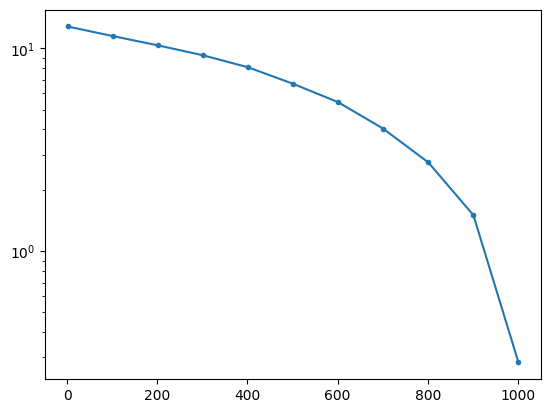

In [14]:
plt.semilogy(compression_size_list, normlist, marker='.')

In [15]:
n_sites = 8
dimH = 2**n_sites
compression_size_list = np.arange(1,dimH,10)
hilbert = nk.hilbert.Spin(0.5, n_sites)

psi_test_rand = np.random.rand(2**n_sites) + np.random.rand(2**n_sites)*1j
cluster_coeffs = fwht_coeffs_in_cluster_col_order(np.log(psi_test_rand), hilbert)

normlist = [np.linalg.norm(np.abs(compress_and_reconstruct_from_cluster_coeffs(cluster_coeffs, comp_size, hilbert) - psi_test_rand)) 
            for comp_size in compression_size_list]


In [16]:
# Jitted + lru_cache helper for FWHT-based compression/reconstruction
# This cell implements a cached metadata builder (by n_sites) and jitted routines.
# It intentionally does not overwrite your earlier functions; it provides new jitted variants
# that you can call during profiling or for production. Target: support up to 16 sites (cache)

from functools import lru_cache, partial
import time
from jax import jit as _jit

@lru_cache(maxsize=8)
def _build_fwht_meta_by_n(n_sites):
    """Build and cache masks/perm tuples for a given n_sites.

    Returns: (masks_tuple, inv_perm_tuple, n)
    """
    # build masks (column order) as Python ints
    masks = [0]
    for cluster_size in range(1, n_sites + 1):
        for comb in itertools.combinations(range(n_sites), cluster_size):
            mask = 0
            for bpos in comb:
                mask |= (1 << bpos)
            masks.append(int(mask))

    # compute perm/inv_perm using a temporary hilbert (same ordering as your fwht helper)
    _hilb = nk.hilbert.Spin(0.5, N=n_sites)
    hstates = np.array(_hilb.all_states())
    b = ((1 - hstates) // 2).astype(np.int64)
    powers = (1 << np.arange(n_sites)).astype(np.int64)
    indices = (b * powers).sum(axis=1)
    perm = np.argsort(indices)
    inv_perm = np.argsort(perm)

    masks_tuple = tuple(masks)
    inv_perm_tuple = tuple(int(x) for x in inv_perm.tolist())
    n = int(2 ** n_sites)
    return masks_tuple, inv_perm_tuple, n


def prepare_fwht_meta_cached(hilbert):
    """User-facing helper: returns cached meta for the hilbert's n_sites."""
    return _build_fwht_meta_by_n(int(hilbert.size))


# Jitted selection and reconstruction routines (expect Python tuples for masks/inv_perm)
# make k (num_kept) a static arg to avoid tracer hashing inside argpartition
@partial(_jit, static_argnums=(1,))
def _get_topk_indices_jit(coefs, k):
    # k is expected to be a Python int (static)
    k = max(int(k), 1)
    absvals = jnp.abs(coefs)
    part = jnp.argpartition(-absvals, k - 1)[:k]
    ordered = part[jnp.argsort(-absvals[part])]
    return ordered


# Mark masks_tuple, inv_perm_tuple and n as static to avoid hashing traced objects
@partial(_jit, static_argnums=(1, 2, 3))
def _reconstruct_from_trunc_jit(trunc, masks_tuple, inv_perm_tuple, n):
    # convert static tuples to jnp arrays (these will be constants in compiled function)
    masks_jnp = jnp.array(masks_tuple, dtype=jnp.int32)
    inv_perm_jnp = jnp.array(inv_perm_tuple, dtype=jnp.int32)

    coeffs_by_index = jnp.zeros(n, dtype=jnp.complex128)
    coeffs_by_index = coeffs_by_index.at[masks_jnp].set(trunc)
    logpsi_by_index = fwht(coeffs_by_index)
    logpsi = logpsi_by_index[inv_perm_jnp]
    psi = jnp.exp(logpsi)
    return psi


# Mark num_kept, masks_tuple, inv_perm_tuple and n as static arguments
@partial(_jit, static_argnums=(1, 2, 3, 4))
def compress_and_reconstruct_cached_jit(full_coeffs, num_kept, masks_tuple, inv_perm_tuple, n):
    # num_kept is static (Python int); pass it to the static _get_topk_indices_jit
    top_idx = _get_topk_indices_jit(full_coeffs, num_kept)
    trunc = jnp.zeros_like(full_coeffs).at[top_idx].set(full_coeffs[top_idx])
    psi = _reconstruct_from_trunc_jit(trunc, masks_tuple, inv_perm_tuple, n)
    return psi


# Convenience Python wrapper that uses the cache and returns a NumPy array
def compress_and_reconstruct_cached(full_coeffs, num_kept, hilbert):
    masks_tuple, inv_perm_tuple, n = prepare_fwht_meta_cached(hilbert)
    full_coeffs_jnp = jnp.array(full_coeffs, dtype=jnp.complex128)
    # ensure num_kept is a Python int when passed
    psi_jnp = compress_and_reconstruct_cached_jit(full_coeffs_jnp, int(num_kept), masks_tuple, inv_perm_tuple, n)
    return np.array(jax.device_get(psi_jnp))


# Quick test with n_sites=10 (change to 16 for final runs; note compilation time will be large)
n_sites_test = 2
hilb_test = nk.hilbert.Spin(0.5, n_sites_test)
psi_test = np.random.rand(2**n_sites_test) + 1j * np.random.rand(2**n_sites_test)
cluster_coeffs_test = fwht_coeffs_in_cluster_col_order(np.log(psi_test), hilb_test)

# warm-up / measure compile time for a specific num_kept
k_test = 2**n_sites_test - 1  # you can vary this
print(f"Preparing cached meta for n_sites={n_sites_test}...", flush=True)
prepare_fwht_meta_cached(hilb_test)  # fill cache (fast)

print("Running first (compile) call...", flush=True)
t0 = time.time()
psi_rec = compress_and_reconstruct_cached(cluster_coeffs_test, k_test, hilb_test)
t1 = time.time()
print(f"First call time: {t1-t0:.2f}s", flush=True)

print("Running second call (should be faster)...", flush=True)
t0 = time.time()
psi_rec2 = compress_and_reconstruct_cached(cluster_coeffs_test, k_test, hilb_test)
t1 = time.time()
print(f"Second call time: {t1-t0:.4f}s", flush=True)

# Verify correctness
err = np.max(np.abs(psi_rec2 - psi_test))
print(f"max abs error against original (after truncation): {err}")


Preparing cached meta for n_sites=2...
Running first (compile) call...
First call time: 0.41s
Running second call (should be faster)...
Second call time: 0.0033s
max abs error against original (after truncation): 0.10036197444210841


### Testing the validity of the compression

In [31]:
# Quick test with n_sites=10 (change to 16 for final runs; note compilation time will be large)
n_sites_test = 4
hilb_test = nk.hilbert.Spin(0.5, n_sites_test)


psi_test = np.random.rand(2**n_sites_test) + 1j * np.random.rand(2**n_sites_test)


cluster_coeffs_test = fwht_coeffs_in_cluster_col_order(np.log(psi_test), hilb_test)

# warm-up / measure compile time for a specific num_kept
k_test = 2**n_sites_test  # you can vary this
# print(f"Preparing cached meta for n_sites={n_sites_test}...", flush=True)
prepare_fwht_meta_cached(hilb_test)  # fill cache (fast)

psi_rec = compress_and_reconstruct_cached(cluster_coeffs_test, k_test, hilb_test)


mask = _get_topk_indices_jit(cluster_coeffs_test, 2) ## correctly returns the mask
coeffs_sel = cluster_coeffs_test[mask] ## correctly retruns bigges coeffs



np.abs(cluster_coeffs_test), np.abs(coeffs_sel), mask, np.isclose(psi_test, psi_rec).all()






(array([0.93591788, 0.21105656, 0.12870269, 0.16811684, 0.02576046,
        0.07402504, 0.08973325, 0.12384822, 0.04473133, 0.09572116,
        0.12236681, 0.11951156, 0.30497362, 0.18890736, 0.13310911,
        0.09778298]),
 array([0.93591788, 0.30497362]),
 Array([ 0, 12], dtype=int32),
 np.True_)

In [18]:
np.random.rand(1)

array([0.60669222])